<a href="https://colab.research.google.com/github/bentondecusin/HJM/blob/main/hjm_3f_US_treasury.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---

title: Use Heath-Jarrow-Morton and Nelson-Siegel to construct US Treasury yield curve
date: '2024-10-26'

tags: [finance, fixed income, bond, hjm]
authors: ['benton']

---

Prerequisite:

- HJM
- Forward rate
- Zero-coupon bond
# Intro
In this blog, we will use HJM to project US Treasury yield curves and price US Treasury Futures. Be aware that this blog is soley for educational purpose. Do not use this for trading


Notations of forward rate:
*   $f(t, T, \Delta)$: forward rate, locked in at time $t$, effective at time $T$, with tenor of $\Delta$ units of time, i.e. borrowing/lending takes place from $T$ to $\Delta$
*   $f(t, T) = f(t, T, 0)$: instant forward rate at time $T$, locked-in at time $t$
*   $r(t, \Delta) = f(t, t, \Delta)$: spot rate for borrowing/lending over [$t$ to $t+\Delta$]
*   $r(t) = f(t, t, \delta)$: instant spot rate for borrowing/lending over [$t$ to $t+\delta$] where $\delta$ is a small time horizton (e.g. overnight)




In [1]:
import warnings
import pandas as pd
import numpy as np
np.random.seed(69420)
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.decomposition import PCA
from scipy.optimize import curve_fit
import scipy.integrate as integrate
from scipy.stats import norm
import time
warnings.filterwarnings("ignore")
plt.style.use('dark_background')

# US Treasury Par Yields
We will use the US Treasury par yields as a proxy of forward rate.

In [2]:
# Real data
df = pd.read_csv("https://lorry.limacon.me/api/public/v2/us_treasury_par_yield")
df = df.set_index('Date')
df.index = pd.to_datetime(df.index, format='%m/%d/%Y', errors='coerce')


In [4]:
par_yields = df.dropna(axis=1, how='any') # Drop any Treasury that has NaN values
par_yields = par_yields.sort_index(ascending=True) # Index by Date
par_yields /= 100
# The x-axis would be tenors:     noted as big Delta
# The y-axis would be past dates: noted as small t
# i.e. par_yields[t][D] is a spot rate r(t,t,D)
tenors_str = np.array(par_yields.columns)
def tenor_str_to_float(tenors_str):
  if isinstance(tenors_str, (list,pd.core.series.Series,np.ndarray)):
    return np.array(list(map(tenor_str_to_float, tenors_str)))
  length, unit = tenors_str.split(' ')
  length = float(length)
  if unit == 'Mo':
    return length / 12
  elif unit == 'Yr':
    return length

def tenor_float_to_str(tenor_float):
  if isinstance(tenor_float, (list,pd.core.series.Series,np.ndarray)):
    return np.array(list(map(tenor_float_to_str, tenor_float)))
  if float(tenor_float) > 1 :
    return f'{tenor_float} Yr'
  else:
    return f'{tenor_float*12} Mo'
tenors_float = tenor_str_to_float(tenors_str)
dates = list(par_yields.index)
print('Sample yield curves')
display(par_yields.iloc[::90,:])

Sample yield curves


,1 Mo,2 Mo,3 Mo,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,30 Yr
Date,,,,,,,,,,,,
2022-01-03,0.0005,0.0006,0.0008,0.0022,0.0040,0.0078,0.0104,0.0137,0.0155,0.0163,0.0205,0.0201
2022-05-12,0.0061,0.0077,0.0096,0.0144,0.0196,0.0256,0.0273,0.0281,0.0286,0.0284,0.0322,0.0300
2022-09-21,0.0259,0.0306,0.0331,0.0386,0.0408,0.0402,0.0398,0.0374,0.0365,0.0351,0.0373,0.0350
2023-02-02,0.0462,0.0465,0.0466,0.0476,0.0464,0.0409,0.0375,0.0349,0.0344,0.0340,0.0367,0.0355
2023-06-12,0.0524,0.0531,0.0540,0.0538,0.0518,0.0455,0.0416,0.0389,0.0382,0.0373,0.0404,0.0387
2023-10-20,0.0556,0.0556,0.0558,0.0554,0.0541,0.0507,0.0493,0.0486,0.0493,0.0493,0.0527,0.0509
2024-03-01,0.0554,0.0549,0.0542,0.0527,0.0494,0.0454,0.0432,0.0417,0.0420,0.0419,0.0446,0.0433
2024-07-11,0.0548,0.0553,0.0544,0.0525,0.0491,0.0450,0.0426,0.0413,0.0415,0.0420,0.0451,0.0441


## *Spot rate* vs *time*

We first plot each tenor's par yield against the time t. There are some interesting patterns, such as rate hikes since 2022, yield inversion in 2022Q3, rate cut in 2024Q3.

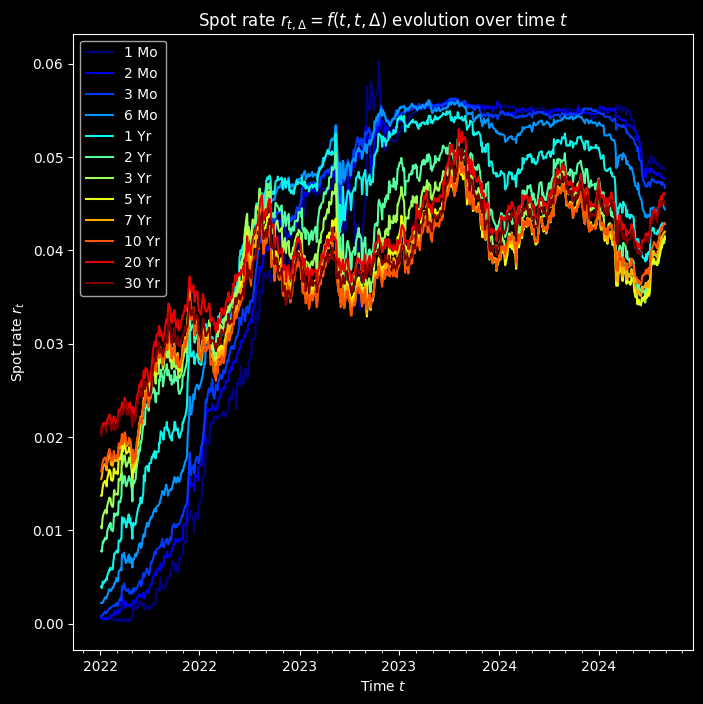

In [5]:
fig, ax = plt.subplots(figsize=(8,8))
ax.set_xlabel(f'Time $t$')
ax.set_ylabel(f'Spot rate $r_t$')
colors = plt.cm.jet(np.linspace(0,1,len(tenors_str)))
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 7)))
ax.xaxis.set_minor_locator(mdates.MonthLocator())
for i, tenor in enumerate(tenors_str):
    ax.plot(par_yields.index, par_yields[tenor], label=tenor, color=colors[i])
ax.legend(loc='best')
plt.title('Spot rate $r_{t, \Delta} = f(t,t,\Delta )$ evolution over time $t$')
plt.show();

## *Spot rate* vs *tenor*
Then we plot the yield against for some selected dates

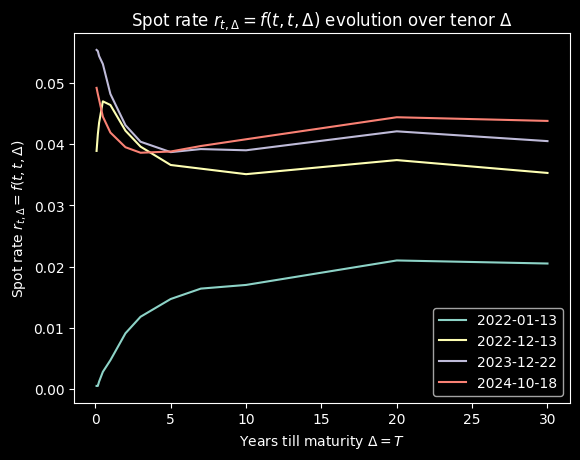

In [6]:
plt.xlabel(f'Years till maturity $\Delta = T$')
plt.ylabel('Spot rate $r_{t, \Delta} = f(t,t,\Delta )$ ')
selected_dates = ['2022-01-13', '2022-12-13', '2023-12-22', '2024-10-18']
colors = plt.cm.jet(np.linspace(0.7,1,len(selected_dates)))
for i, date_ in enumerate(selected_dates):
    plt.plot(tenors_float, par_yields.loc[date_], label=date_)
plt.legend(loc='best')
plt.title('Spot rate $r_{t, \Delta} = f(t,t,\Delta )$ evolution over tenor $\Delta$')
plt.show();

## Backgound 
The US had been in a low interest rate environment since COVID. Then in March 2022, the Fed had been raising effective federal funds rate (EFFR) till July 2023. Then we see the first rate cut since then in July 2024. Over the this time the entire curve shifts up. Yield curve inverted in late 2022. And after the rate cut on July 31, 2024, the rate steepens. Hmm, hope J Pow makes the soft landing :))

# Volatility of yields
Enough econ yapping, back to business. We want to analyze the volatilities so we can cook the term strucure using HJM. We calculate the overnight (close to instant) change of spot rate, defined as $dr_t = r_t - r_{t-1} \Leftrightarrow df(t,t) = df(t,t) - df(t-1,t-1)$, to represent the yield volatility
Ok, what's next, we want to find a way to express this volatility using linear terms

Latest 5  dr(t)


,1 Mo,2 Mo,3 Mo,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,30 Yr
Date,,,,,,,,,,,,
2024-10-23,-0.001587,-0.003175,-0.004762,0.000000,-0.003175,0.000000,-0.001587,-0.003175,-0.003175,-0.004762,-0.006350,-0.006350
2024-10-24,0.003175,0.001587,0.004762,0.004762,0.006350,0.006350,0.004762,0.006350,0.004762,0.006350,0.006350,0.006350
2024-10-25,-0.001587,-0.003175,-0.004762,-0.007937,-0.001587,0.001587,0.006350,0.006350,0.006350,0.004762,0.004762,0.003175
2024-10-28,0.000000,0.000000,0.000000,-0.001587,0.001587,-0.001587,-0.001587,0.000000,-0.001587,0.000000,0.000000,-0.001587
2024-10-29,-0.001587,0.000000,-0.004762,-0.001587,-0.001587,0.006350,0.009525,0.004762,0.003175,0.001587,-0.001587,-0.004762


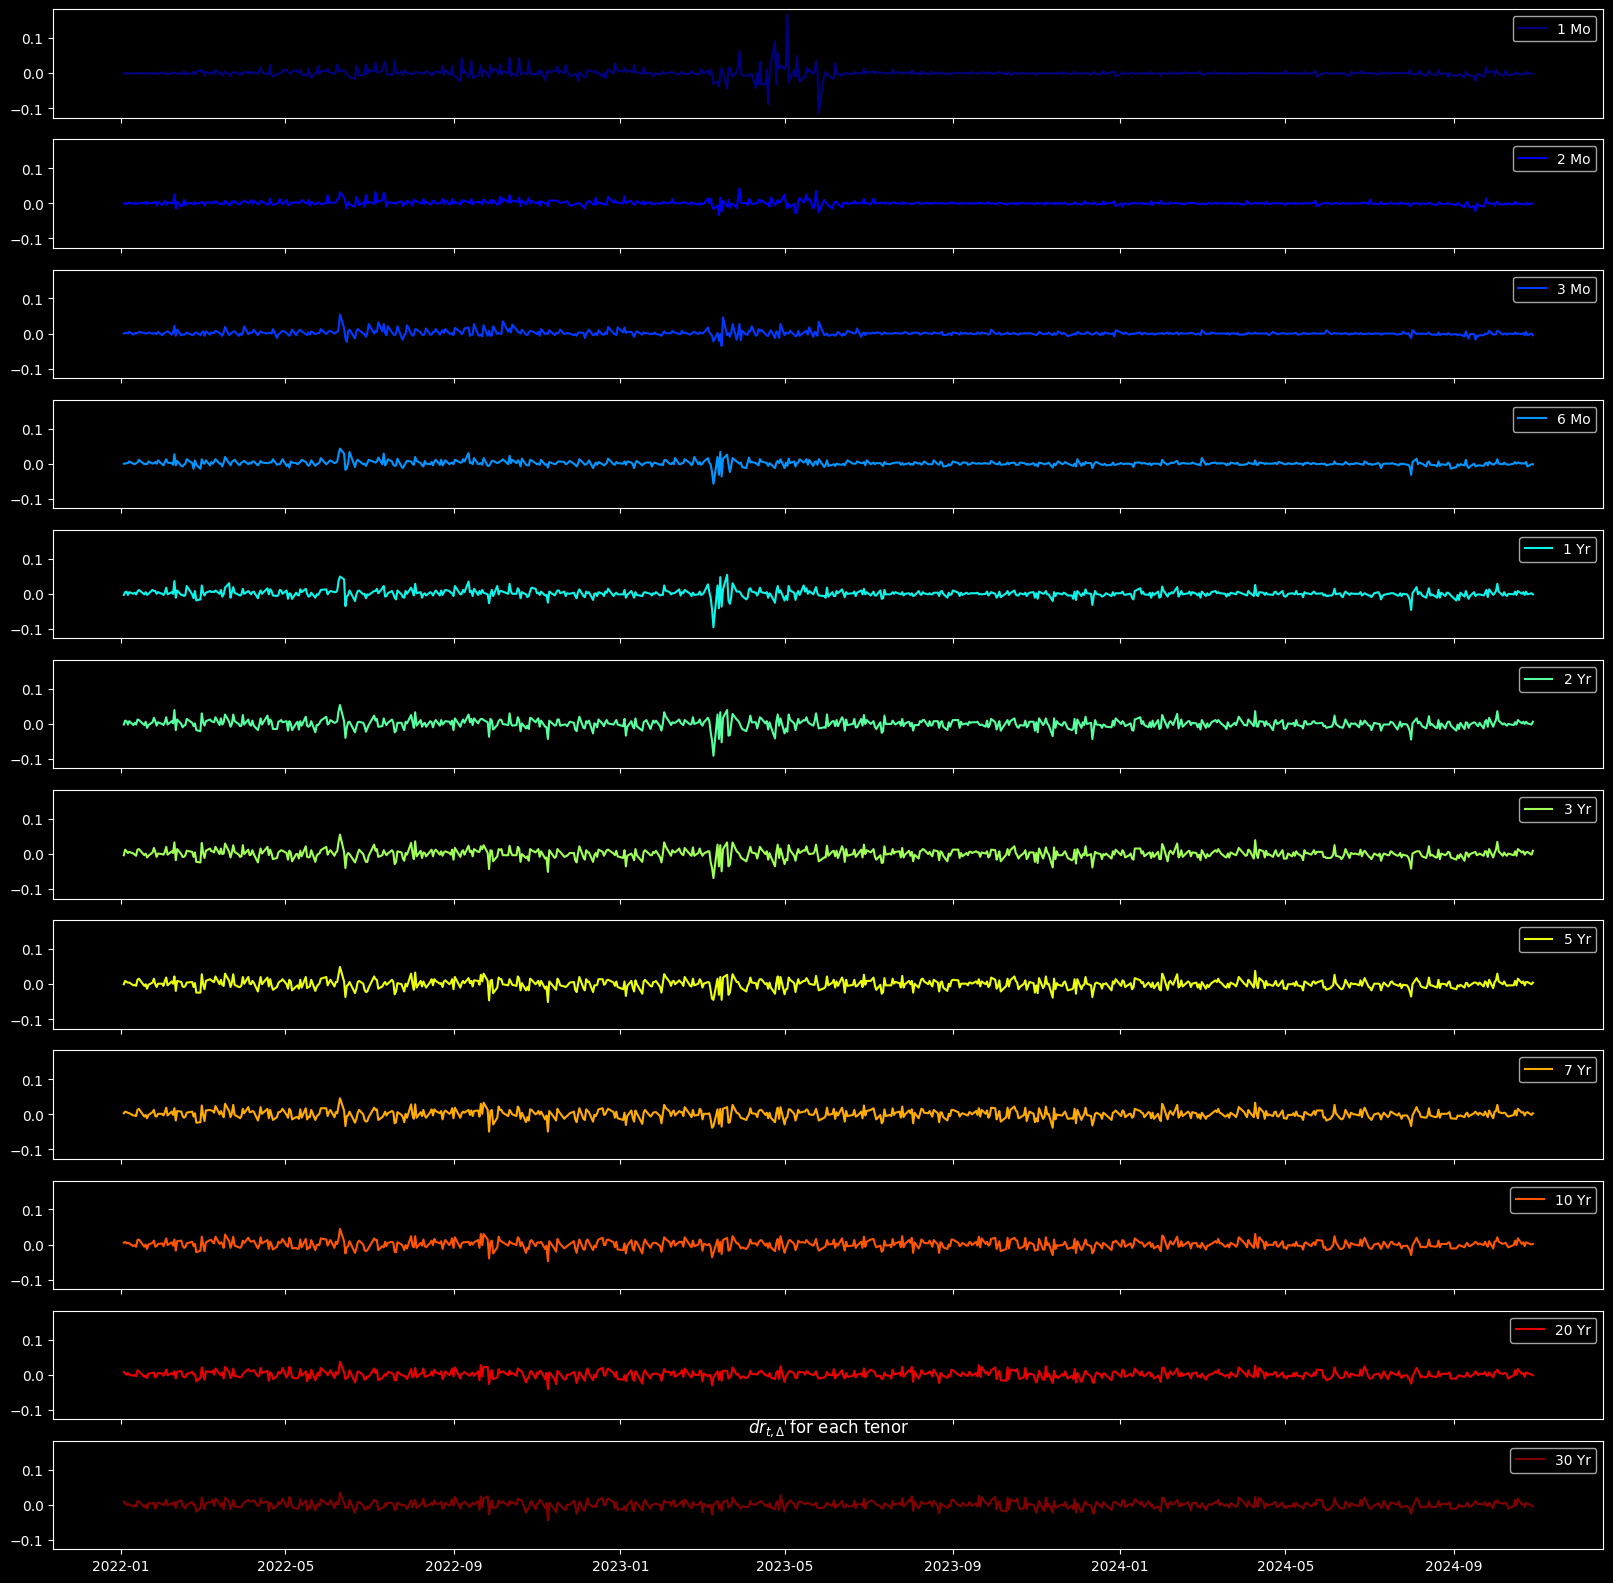

In [7]:
dftt = pd.DataFrame(np.diff(par_yields, axis=0),
                    index=par_yields.index[:-1],
                    columns=par_yields.columns)
# Remove the first date, n rows -> n-1 rows
# dftt[i,j] = ftt[i,j] - ftt[i-1][j]
dftt = dftt * np.sqrt(252)  # Anualize df(t,t)

print("Latest 5  dr(t)")
display(dftt.iloc[-5:]) # TOP 5 dftt
colors = plt.cm.jet(np.linspace(0,1,len(tenors_str)))

fig, ax = plt.subplots(len(tenors_str), sharex=True, sharey=True, figsize=(20,20))
for i, tenor in enumerate(tenors_str):
    ax[i].plot(dftt.index, dftt[tenor], color=colors[i], label = tenor)
    ax[i].legend(loc='best')
plt.title('$dr_{t, \Delta}$ for each tenor')

plt.show()


One more yapping, look at the 1-month T-bill yields, they are mad volatile. We will see the reasoning later in the blog.
# PCA
## All factors  
To express the 'overall' volatility, which reflects the volatility of the whole term structure, not just the short-term, not just the long-term, but the whole structure. We are going to use PCA to find major components that explain the volatilities.

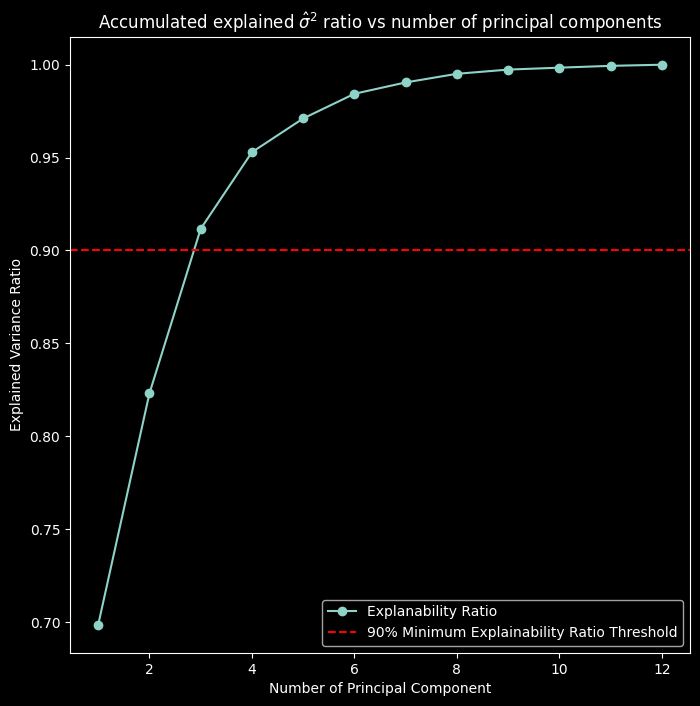

In [8]:
n_components = len(tenors_str)
pca = PCA(n_components=n_components, svd_solver='full') # Get at least 10 explanable tenors
pca.fit(dftt)
acc_explained_var_ratio = pca.explained_variance_ratio_.cumsum()
fig, ax = plt.subplots(figsize=(8,8))
ax.plot(np.arange(1, n_components+1), acc_explained_var_ratio, marker='o', label='Explanability Ratio')
ax.set_xlabel('Number of Principal Component')
ax.set_ylabel('Explained Variance Ratio')
ax.axhline(0.9, color='red', label='90% Minimum Explainability Ratio Threshold', ls='--')
ax.legend(loc='best')
plt.title('Accumulated explained $\hat{\sigma}^2$ ratio vs number of principal components')
plt.show()


Cool, we got all the components. It appears that first 3 principal components are sufficient as they could explain 90% of the volatilities.
## Loadings
But before we examine the first two component, let's quickly revisit **loadings**     
$\text{Loadings} = \text{eigen vector }\cdot \sqrt{\text{eigen values }}$  
What we did in PCA was decompoing covariance matrix into a scalar part (eigen value) and a vector part (eigen vector). As a weighed version of eigen vector, loadings are regression factors (not necessarily correlations), and inidcate how strongly the *volatiliy of a tenor* and a *principal component* are associated

Loadings: eigen vectors scaled by eigen values


,pca0,pca1,pca2
1 Mo,0.000612,0.012857,-0.001340
2 Mo,0.002004,0.002959,0.002027
3 Mo,0.002891,0.000939,0.002980
6 Mo,0.005029,0.000474,0.003770
1 Yr,0.008778,0.000372,0.004895
2 Yr,0.012155,-0.000057,0.003628
3 Yr,0.012741,-0.000188,0.001774
5 Yr,0.012545,-0.000367,-0.000437
7 Yr,0.012011,-0.000404,-0.001988
10 Yr,0.010782,-0.000305,-0.003121


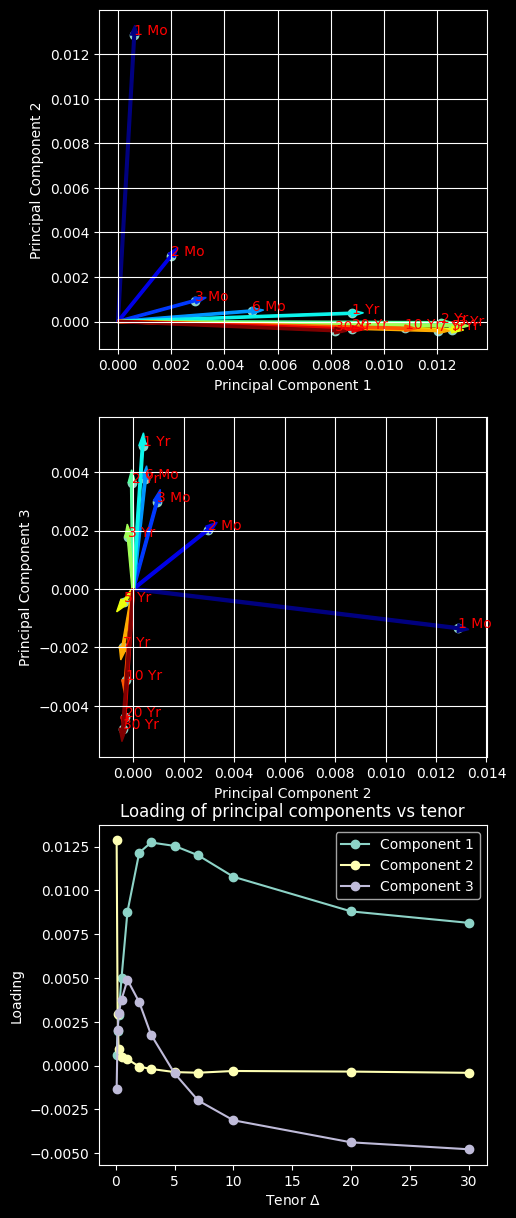

In [9]:
pca = PCA(n_components=3, svd_solver='full') # Get at least 10 explanable tenors
pca.fit(dftt) 
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
print('Loadings: eigen vectors scaled by eigen values')
display(pd.DataFrame(loadings, columns=pca.get_feature_names_out(), index=tenors_str))

fig, ax = plt.subplots(3, 1, figsize=(5,15))
for j in range(2):
  pcX, pcY = j, j+1
  ax[j].scatter(loadings[:, pcX], loadings[:, pcY])
  ax[j].set_xlabel(f'Principal Component {pcX+1}')
  ax[j].set_ylabel(f'Principal Component {pcY+1}')
  # Add variable labels to the plot
  colors = plt.cm.jet(np.linspace(0,1,len(tenors_str)))
  for i, tenor in enumerate(tenors_str):
      ax[j].annotate(tenor, xy=(loadings[i, pcX], loadings[i, pcY]), color='red')
      ax[j].arrow(x=0, y=0, dx=loadings[i, pcX], dy=loadings[i, pcY], color=colors[i], width=1/10000)
  ax[j].grid(True)
ax[2].plot(tenors_float, loadings, marker='o', label=[f'Component {i+1}' for i in range(3)])
ax[2].legend(loc='best')
ax[2].set_xlabel('Tenor $\Delta$')
ax[2].set_ylabel('Loading')
ax[2].set_title('Loading of principal components vs tenor')

plt.show()

Note that principal components are now new magical features/variable/factors composed of volatities of differently-tenored Treasuries.  
Quick review on Treasuries naming:
- T-bills are the short-term (tenor <= 1 yr) Treasuries
- T-notes are the mid-term (1 < tenor < 10 yr) Treasuries
- T-bonds are the long-term (10yr < tenor ) Treasuries


Based on the loading plots, we have some interesting insights:
1.   The 1st principal component primarily explains the volatility of T-note (mid-term) and T-bond (long-term) par yield
2.   The 2nd principal component primarily explains the volatility of the 1-month T-bill (short-term) par yield
3.   The 3rd principal component explains the negative association between volatility of T-bill (short-term) and that of T-bond (long-term)

This aligns with the reality that, short-term yields are more directly affected by monetary policies than long-term yield. Although short-term and long-term yields usually move in the same direction, but the latter move in a smaller magnitude. This is because long-term yields reflect the martket's expecation for economy performance.
When the yield curve flatten or steepens, two ends of the curve could move in different direction, or same direction but in a significantly different magnitudes.

In other words, the 1st principal component explains the effect of monetary policy on left-hand side of term rate evolution. The 2nd principal component explains the parallel shift of yield rates caused by the market's confidence in the economy. The 3rd principal component, along with the 1st and 2nd, explains the behavior of steepening and flattening

# Volatility fitting

Now we want to express each volatility component $\sigma(t, T, T+\Delta)$ as a function of *tenor* $\Delta$.

How do we want to fit the volatility component then? Of course there are many fitting models in our arsenal, incluidng some badass like deep neuron network. But for demonstration purpose, we will use the famous [Nelson-Siegel](https://www.jstor.org/stable/2352957) model, which is usually used for yield curve modeling (interestingly not for yield volatility).

[]

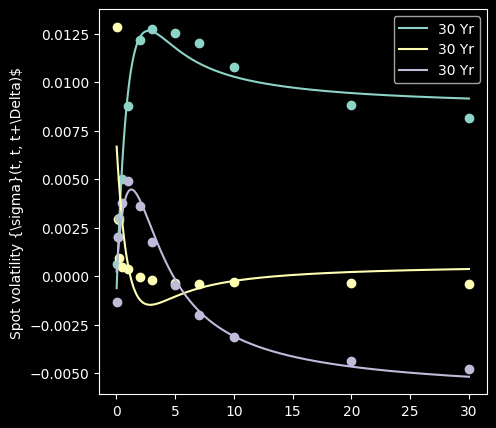

In [10]:
def nelson_siege(tau, b0, b1, b2):
      decay = b1 * (1-np.exp(-tau))/tau
      hump = b2 * ((1-np.exp(-tau))/tau -np.exp(-tau))
      return b0 + decay + hump

class Volatility:
  def __init__(self, fit_fn):
    self.fit_fn = fit_fn
    self.fit_params = []

  def fit(self, loading, tenors_float):
    self.fit_params = []
    for i, loading in enumerate(loadings.T):
      popt, _ = curve_fit(self.fit_fn, tenors_float, loading, method='lm')
      self.fit_params.append(popt)
  def predict(self, tenors):
    return np.array([nelson_siege(tenors, *popt) for popt in self.fit_params])

fig, ax = plt.subplots(figsize=(5,5))
vola = Volatility(nelson_siege)
vola.fit(loadings, tenors_float)
tenors_sim = np.linspace(0, 30, 1000)
vola_curves = vola.predict(tenors_sim)

for i, component in enumerate(loadings.T):
  ax.plot(tenors_sim, vola_curves[i], label=tenor)
  ax.scatter(tenors_float, component)
ax.set_label('Tenor $\Delta$')
ax.set_ylabel('Spot volatility {\sigma}(t, t, t+\Delta)$')
ax.legend(loc='best')
ax.plot()


It fits quite well.

After analyzing the **past** rates, finally, let's project **future** rates! But before that, we need **present** rates, the spot rate $r_0(t_0, \Delta) =  f(t_0,t_0, \Delta)$

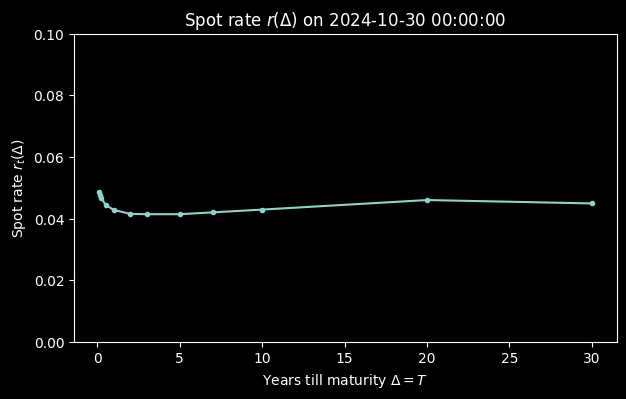

In [11]:
# Spot
spot_yield = par_yields.iloc[-1,:] # Latest fwd rate
fig, ax = plt.subplots(figsize=(7,4))
ax.plot(tenors_float, spot_yield, marker='.')
ax.set_ylim(0, 0.1)
ax.set_xlabel(f'Years till maturity $\Delta = T$')
ax.set_ylabel(f'Spot rate $r_t(\Delta)$')
ax.set_title(f'Spot rate $r(\Delta)$ on {par_yields.index[-1]}')
plt.show()

Then we simulate the drift term for a range of $\tau$

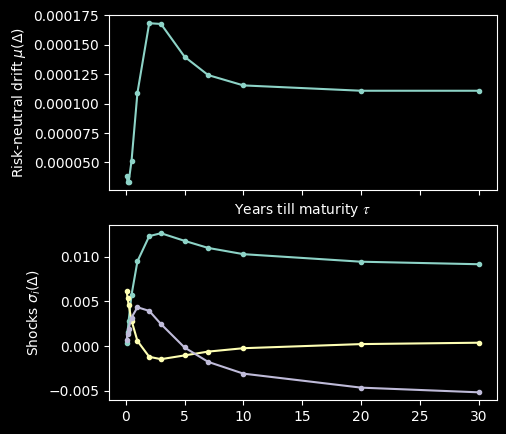

In [12]:
def shock_fn(tau):
  #return n * m matrix where n = num principal components and m = len(tau)
  return vola.predict(tau)

def drift_fn(tau):
  shocks = shock_fn(tau)
  # If tau a list-like
  return (shocks * shocks).sum(axis=0)

foward_tenor = np.linspace(0, 5, 1000)
spot_drift = drift_fn(tenors_float)

fig, ax = plt.subplots(2,1, figsize=(5, 5), sharex=True)
ax[0].plot(tenors_float, spot_drift, marker='.')
ax[0].set_xlabel(f'Years till maturity $ 𝜏$')
ax[0].set_ylabel(f'Risk-neutral drift $\mu(\Delta) $')
ax[0].xaxis.tick_bottom()

ax[1].plot(tenors_float, shock_fn(tenors_float).T, marker='.')
ax[1].set_ylabel(f'Shocks $\sigma_i(\Delta) $')

plt.show()


We simulate $r(t+dt)$ by
$$r(t+dt)=r(t) + d{f} \cdot dt \\  
=[\sum_{i=1}^k {v}_i(t,\Delta)^2]dt + \sum_{i=1}^k v_i(t,\Delta)dW_i(t) \\
$$

# Simulate Forward Rate

In [20]:
import numpy as np
from concurrent.futures import ProcessPoolExecutor, as_completed
import os


class ForwardRateSimulator:
  def __init__(self, vola, drift_fn, shock_fn, spot, fwd_tenor, fwd_period, step=1/365):
     # Range of tenors in years. This is tau's in f(t,T,T+tau)
    self.fwd_tenors_str = fwd_tenor if isinstance(fwd_tenor[0], str) else tenor_float_to_str(fwd_tenor)
    self.fwd_tenors_float = fwd_tenor if not isinstance(fwd_tenor[0], str) else tenor_str_to_float (fwd_tenor)
    self.fwd_period = fwd_period # Time to lock-in date in years. This is T in f(t,T,T+tau)
    self.step = step # Increment steps
    self.spot = spot # Initial value f(0,0,tau) for all tau in fwd_tenors
    self.vola = vola
    self.drift_fn = drift_fn
    self.shock_fn = shock_fn

  def simulateOne(self):
    nSteps = int(self.fwd_period / self.step)  # Total number of steps
    # n by m matrix
    # where n = number of timepoints in the future
    # m = number of desired forward tenors
    np.random.seed((os.getpid() * int(time.time()))%100000)
    paths = np.zeros((nSteps, len(self.fwd_tenors_float)))
    paths[0] = self.spot[self.fwd_tenors_str]
    T = self.fwd_period
    dT = np.diff(tenor_str_to_float(list(self.spot.index)))
    dt = self.step
    # Simulate f(t,T,T+tau) for all t up to T
    for t in range(1,len(paths)):
      prev_f = paths[t-1]
      drift = drift_fn(self.fwd_tenors_float)
      shocks = shock_fn(self.fwd_tenors_float)
      
      curr_f = prev_f + drift * dt \
              + (shocks * norm.rvs(size=(shocks.shape)) * np.sqrt(dt)).sum(axis=0)
      paths[t] = curr_f
    return pd.DataFrame(paths, columns=self.fwd_tenors_str)

  def simulateN(self, nTrials, nProc=os.cpu_count()-1):
    results = []
    # Set up a process pool to distribute the simulation
    with ProcessPoolExecutor(max_workers=os.cpu_count() - 1) as ex:
        futures = [ex.submit(self.simulateOne) for _ in range(nTrials)]
        for i, fut in enumerate(as_completed(futures)):
            results.append(fut.result())
    return np.array(results)
sim_tenors = ['1 Mo', '1 Yr', '5 Yr', '7 Yr', '10 Yr']
steps = 1/365 # Year -> day
fut_horizon = 3 #Years
nTrial = 10000
simulator = ForwardRateSimulator(vola, drift_fn, shock_fn, spot_yield, sim_tenors, fut_horizon, steps)
res = simulator.simulateN(nTrial)

Done with simulaiton, now let's plot out the sample paths for different treasuries

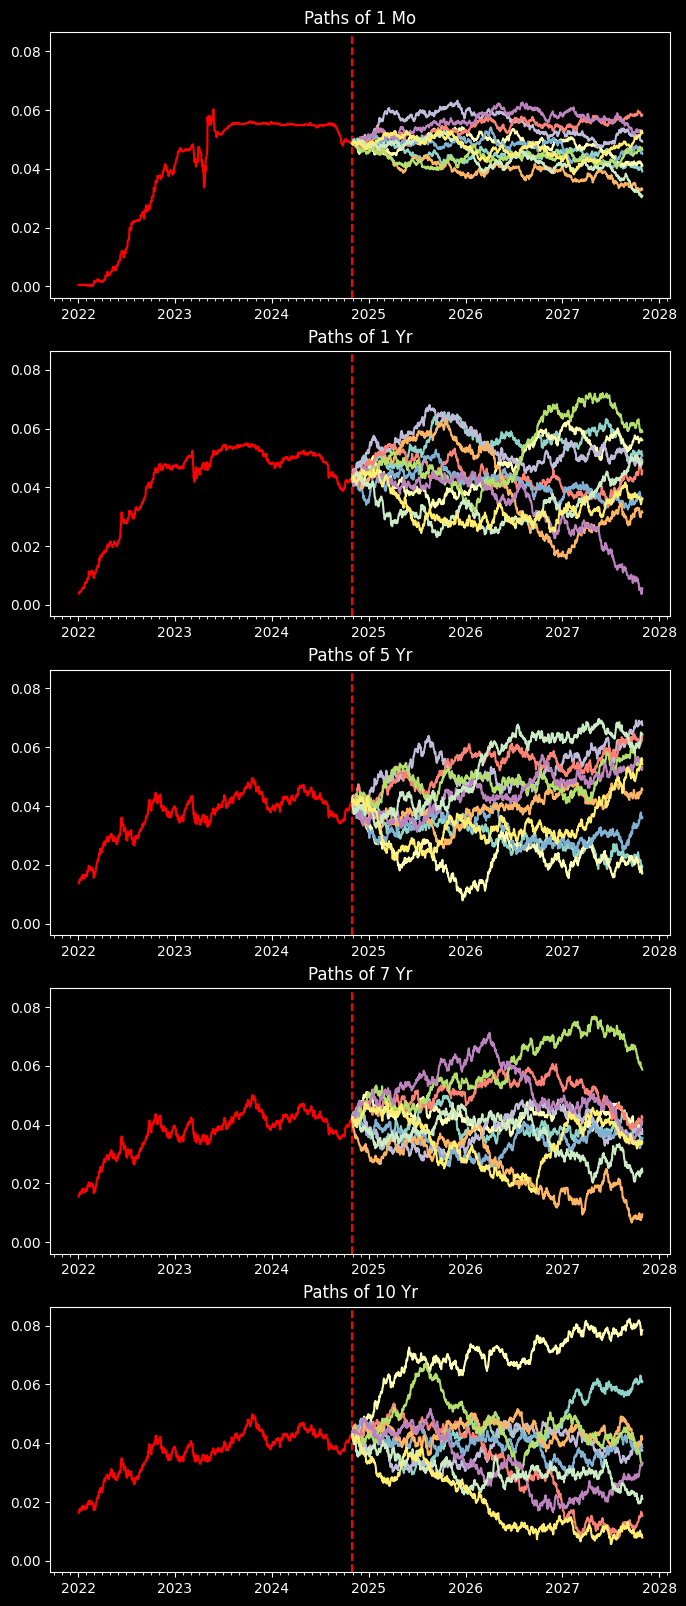

In [21]:
fig, ax = plt.subplots(len(sim_tenors), 1, figsize=(8,4 * len(sim_tenors)), sharey=True)
present = np.datetime64(par_yields.index[-1], 'D')
future_timeline = present + np.array([i for i in range(int(fut_horizon/steps))])
for i, tenor in enumerate(sim_tenors):
  ax[i].xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1)))
  ax[i].xaxis.set_minor_locator(mdates.MonthLocator())
  ax[i].plot(par_yields.index, par_yields[tenor], color='red')
  ax[i].axvline(par_yields.index[-1], color='red', ls='--')
  ax[i].set_title(f"Paths of {tenor}")
  # Display up to 10 path
  for sim_i, sim in enumerate(res):
    if sim_i < 10:
      ax[i].plot(future_timeline, sim.T[i])

We take the average of the path

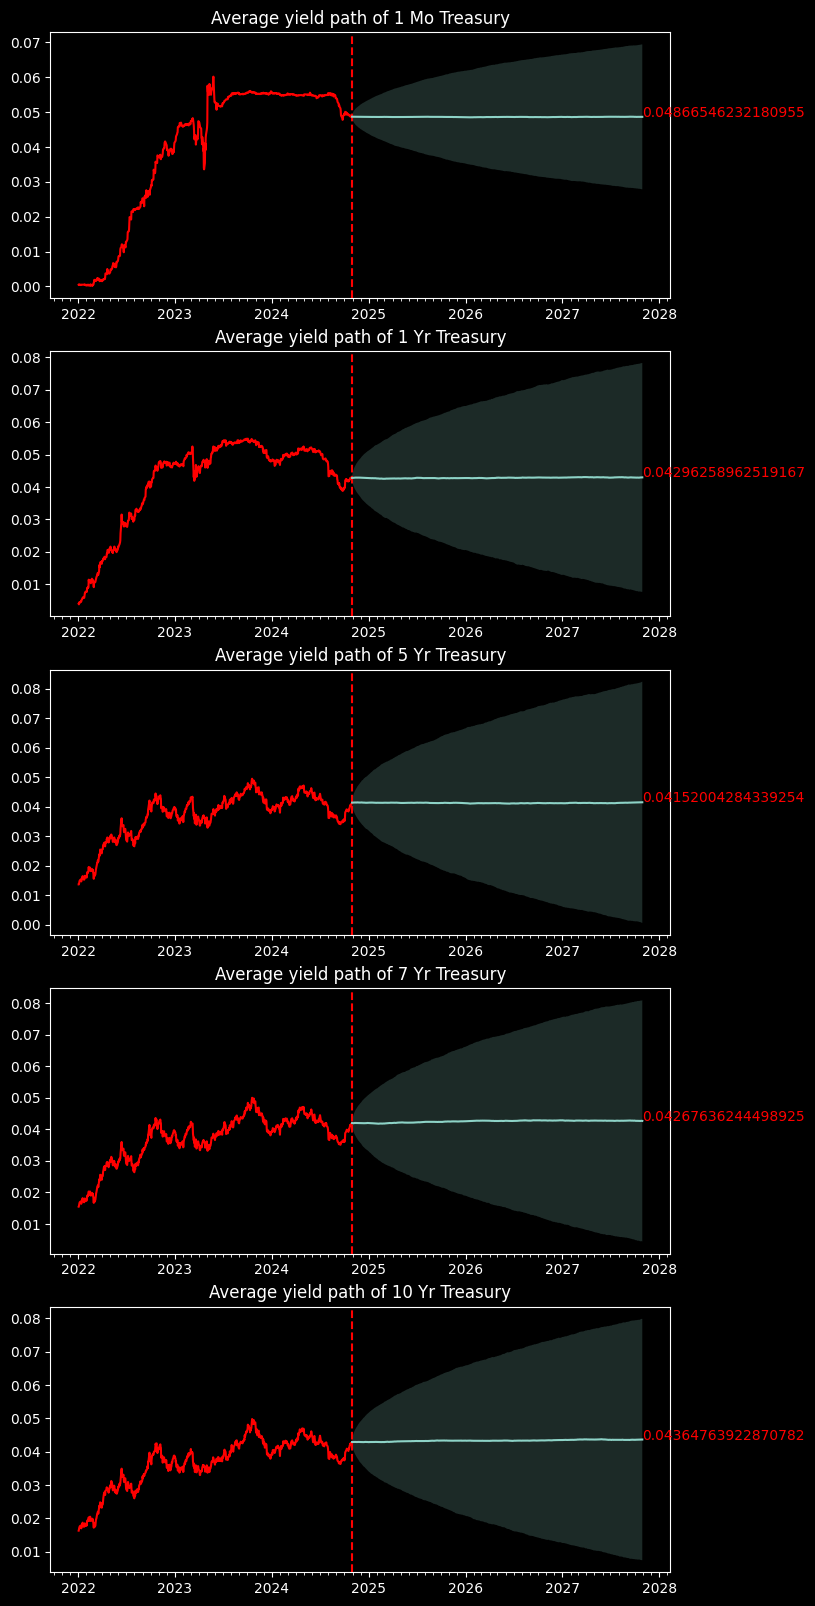

In [22]:
fig, ax = plt.subplots(len(sim_tenors), 1, figsize=(8,4 * len(sim_tenors)))
for i, tenor in enumerate(sim_tenors):
  path_mean = res.mean(axis=0).T[i]
  path_CI = 1.96 * res.std(axis=0).T[i]
  ax[i].xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1)))
  ax[i].xaxis.set_minor_locator(mdates.MonthLocator())
  ax[i].plot(par_yields.index, par_yields[tenor], color='red')
  ax[i].axvline(par_yields.index[-1], color='red', ls='--')
  ax[i].set_title(f"Average yield path of {tenor} Treasury")
  # Display up to 10 path
  ax[i].plot(future_timeline, path_mean)
  ax[i].fill_between(future_timeline, path_mean - path_CI, path_mean + path_CI, alpha=0.2)
  ax[i].annotate(path_mean[-1], xy=(future_timeline[-1], path_mean[-1]), color='red')

And here we go, we got several projected US Treasury yield over the next 3 years. It's trivial to say that average projected rates are nearly same as spot rate. This is because we have a risk-neutral drift that is nearly 0. Othwesie the treasury yields will go to finity as time grows. Nevertheless, we can use the simulations backed by HJM to profile the market risk.    
## What's next?
In this blog, we focus on the spot rate $f(t,t,\Delta)$ for different $\Delta$, what would the term evolution look like if we are simulating $f(t,t+\tau,\delta)$? 
Spoil alert, it will go upward as it has a positive risk-neutral drift. We will show that in the future blogs. We will "cook" the UK forward yield curve :))